In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [229]:
df = pd.read_csv('../data/6hour.csv')
df.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time']
df['open_time'] = pd.to_datetime(df['open_time'] * 1000, unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df = df[df['open_time'] > '2021-01-01']
df['ma'] = df['close_price'].rolling(10).mean()
df['change'] = df['close_price'].pct_change() * 100
df['future_change'] = df['change'].shift(-1)
df = df.dropna()

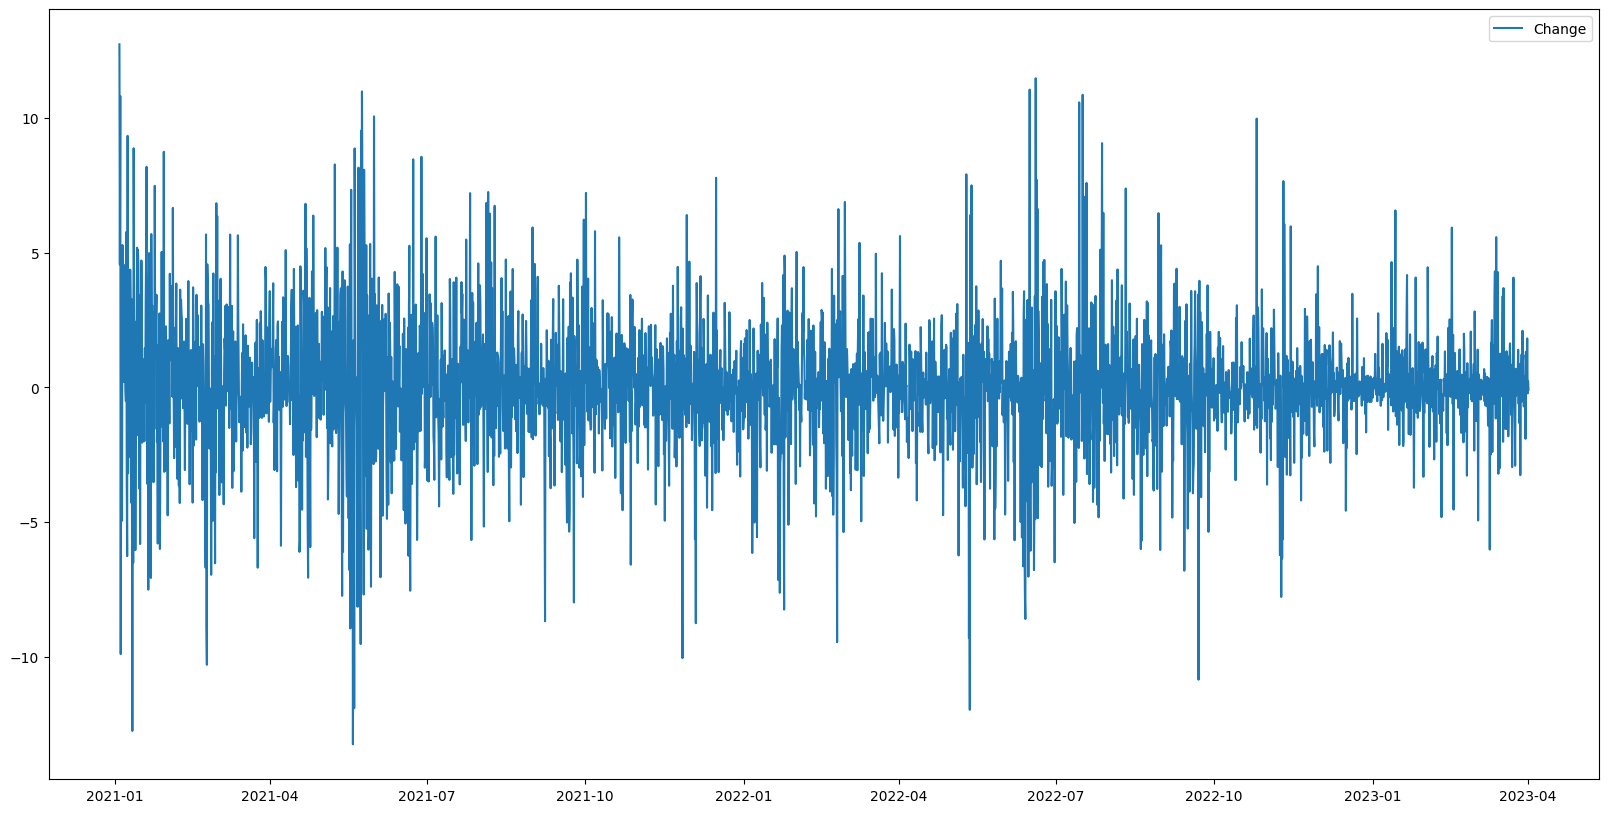

In [230]:
plt.figure(figsize=(20, 10))
plt.plot(df['close_time'], df['change'], label='Change')
plt.legend()
plt.show()

In [231]:
features = ['open_price', 'high_price', 'low_price', 'volume', 'ma']
target = 'future_change'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Mean Squared Error: 5.474867711083365


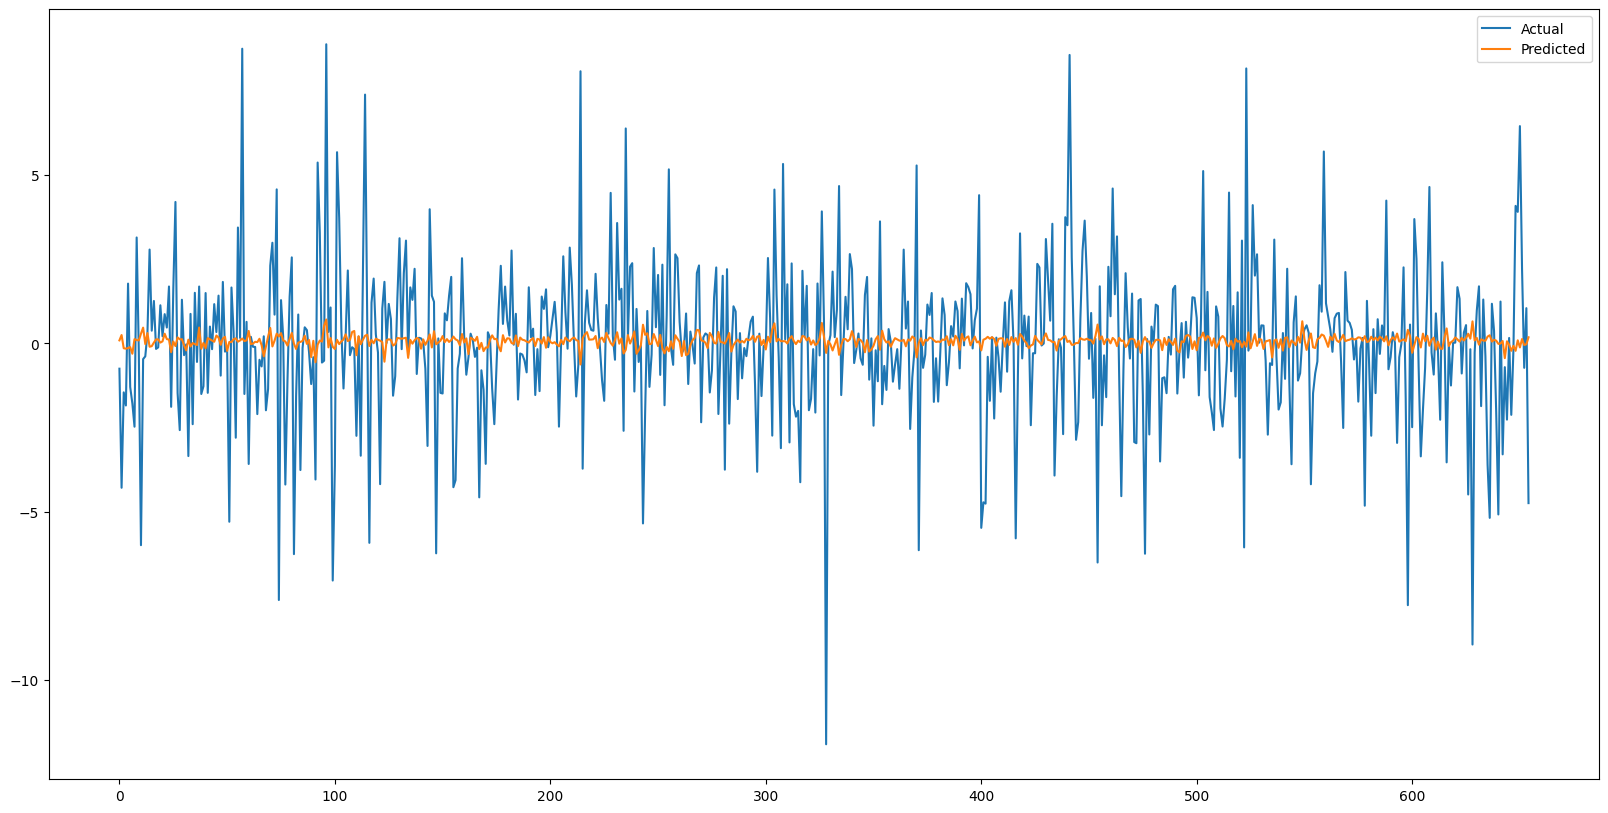

In [232]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
plt.figure(figsize=(20, 10))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [233]:
def simulate_trading(close_price, predicted_change, trade_threshold):
    money = 100
    coins = 0
    for i in range(len(predicted_change)):
        if predicted_change[i] > trade_threshold:
            coins += money / close_price[i]
            money = 0
        elif predicted_change[i] < trade_threshold:
            money += coins * close_price[i]
            coins = 0
    return money + coins * close_price[-1]

def simulate_holding(test):
    money = 100
    return money + (money / test[0]) * test[-1]

In [253]:
def read_train_evalute(path='../data/1day.csv', rolling=5, test_size=0.2, trading_threshold=0, plot=False, model=LinearRegression()):
    df = pd.read_csv(path)
    df.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time']
    df['open_time'] = pd.to_datetime(df['open_time'] * 1000, unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[df['open_time'] > '2020-01-01']
    df['ma'] = df['close_price'].rolling(rolling).mean()
    df['change'] = df['close_price'].pct_change() * 100
    df['future_change'] = df['change'].shift(-1)
    
    df = df.dropna()
    features = ['open_price', 'high_price', 'low_price', 'volume', 'ma']
    target = 'future_change'
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    # model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(y_test.values, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.legend()
        plt.show()
    close_price = df['close_price'].values[-len(y_pred):]
    predicted_change = y_pred
    trading_result = simulate_trading(close_price, predicted_change, trading_threshold)
    holding_result = simulate_holding(close_price)
    
    return trading_result, holding_result

In [235]:
read_train_evalute(path='../data/1month.csv', rolling=5, test_size=0.2, trading_threshold=0, plot=False)

Mean Squared Error: 1385.9987017613967
Trading Simulation Result: 125.77599925837801
Holding Simulation Result: 224.66659642362575


In [246]:
file_names = ['1minute', '3minute', '5minute', '15minute', '30minute', '1hour', '2hour', '4hour', '6hour', '8hour', '12hour', '1day', '1week']

In [251]:
best_result = 0
best_file_name = ''
best_rolling = 0
hold_result = 0

for file_name in file_names[6:]:
    for rolling in [5, 10, 20, 30, 40, 50]:
        trading_result, holding_result = read_train_evalute(path=f'../data/{file_name}.csv', rolling=rolling, test_size=0.2, trading_threshold=0, plot=False)
        if trading_result > best_result:
            hold_result = holding_result
            best_result = trading_result
            best_file_name = file_name
            best_rolling = rolling


print(f'Best result: {best_result}')
print(f'Best file name: {best_file_name}')
print(f'Best rolling: {best_rolling}')
print(f'Holding result: {hold_result}')

Mean Squared Error: 1.801179602937429
Mean Squared Error: 1.9400142655028219
Mean Squared Error: 1.9356488928584097
Mean Squared Error: 1.850070259144582
Mean Squared Error: 2.233547530811892
Mean Squared Error: 2.090551979052825
Mean Squared Error: 3.7794233562981314
Mean Squared Error: 4.0777856464891284
Mean Squared Error: 3.761226265524058
Mean Squared Error: 3.743231112558793
Mean Squared Error: 3.8184169818644844
Mean Squared Error: 3.909360939385991
Mean Squared Error: 5.258174327584769
Mean Squared Error: 5.4674557855581085
Mean Squared Error: 4.830790830245954
Mean Squared Error: 5.289171386300031
Mean Squared Error: 4.7268885764491095
Mean Squared Error: 4.831491522221175
Mean Squared Error: 6.86193027322332
Mean Squared Error: 7.9608238084744105
Mean Squared Error: 9.01333143433052
Mean Squared Error: 8.832011240265052
Mean Squared Error: 9.847678256369763
Mean Squared Error: 7.707362970017886
Mean Squared Error: 10.390100529550274
Mean Squared Error: 9.99358337158895
Mean S

In [254]:
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    SVR(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    XGBRegressor(),
    KNeighborsRegressor()
]

model_names = [
    'LinearRegression',
    'GradientBoostingRegressor',
    'RandomForestRegressor',
    'SVR',
    'Ridge',
    'Lasso',
    'ElasticNet',
    'XGBRegressor',
    'KNeighborsRegressor'
]

best_result = 0
best_file_name = ''
best_rolling = 0
best_model_name = ''
hold_result = 0

for file_name in file_names[6:]:
    for rolling in [5, 10, 20, 30, 40, 50]:
        for model, model_name in zip(models, model_names):
            trading_result, holding_result = read_train_evalute(path=f'../data/{file_name}.csv', rolling=rolling, test_size=0.2, trading_threshold=0, plot=False, model=model)
            if trading_result > best_result:
                hold_result = holding_result
                best_result = trading_result
                best_file_name = file_name
                best_rolling = rolling
                best_model_name = model_name


print(f'Best result: {best_result}')
print(f'Best file name: {best_file_name}')
print(f'Best rolling: {best_rolling}')
print(f'Best model name: {best_model_name}')
print(f'Holding result: {hold_result}')


Mean Squared Error: 1.801179602937429
Mean Squared Error: 2.155662718506191
Mean Squared Error: 1.9400142655028219
Mean Squared Error: 1.9538303466061815
Mean Squared Error: 1.9356488928584097
Mean Squared Error: 2.0403487180126523
Mean Squared Error: 1.850070259144582
Mean Squared Error: 2.250980298882281
Mean Squared Error: 2.233547530811892
Mean Squared Error: 2.2905044459832595
Mean Squared Error: 2.090551979052825
Mean Squared Error: 2.182278523852666
Mean Squared Error: 3.7794233562981314
Mean Squared Error: 4.197899835913988
Mean Squared Error: 4.0777856464891284
Mean Squared Error: 4.1816143003616535
Mean Squared Error: 3.761226265524058
Mean Squared Error: 3.8518142683841567
Mean Squared Error: 3.743231112558793
Mean Squared Error: 3.7443216797506533
Mean Squared Error: 3.8184169818644844
Mean Squared Error: 3.9855259770464877
Mean Squared Error: 3.909360939385991
Mean Squared Error: 4.070512678828148
Mean Squared Error: 5.258174327584769
Mean Squared Error: 5.860062300730562
